# Image Color Compression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import PIL

from scipy.spatial.distance import cdist

## Tải dữ liệu hình ảnh để demo

In [ ]:
# get data demo

#!wget -qO- https://cdn.discordapp.com/attachments/817270986423664670/843522898127880232/img.zip > img.zip

!curl -O https://cdn.discordapp.com/attachments/817270986423664670/843522898127880232/img.zip

!unzip -o img.zip

%ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2734k  100 2734k    0     0  14.5M      0 --:--:-- --:--:-- --:--:-- 14.5M
Archive:  img.zip
  inflating: img/African lion 1920x1080.jpg  
  inflating: img/Angkor, Cambodia 1920x1080.jpg  
  inflating: img/Baler, Philippines 1920x1080.jpg  
  inflating: img/Baltic seashore, Germany 1920x1080.jpg  
  inflating: img/Bardenas Reales, Spain 1920x1080.jpg  
img/  img.zip  reduced.png  sample_data/


Lưu danh sách các tên file hình ảnh vào biến `list_image_name`.

In [ ]:
list_image_name = !ls -1 img/
list_image_name = [i[1:-1] for i in list_image_name]
list_image_name

['African lion 1920x1080.jpg',
 'Angkor, Cambodia 1920x1080.jpg',
 'Baler, Philippines 1920x1080.jpg',
 'Baltic seashore, Germany 1920x1080.jpg',
 'Bardenas Reales, Spain 1920x1080.jpg']

## Xây dựng thuật toán Kmeans 

### Các hàm hỗ trợ

Hàm tính khoảng cách giữa 2 vector: dùng khoảng cách Ecluid.  

In [ ]:
def vec_distance(A, B):  
    return np.sqrt(np.sum(((np.array(A) - np.array(B))**2), axis= 1))

vec_distance([np.array([1,1,1]), np.array([1,1,2])], np.array([2,3,4]))

array([3.74165739, 3.        ])

Hàm gán nhãn cho các cụm  

In [ ]:
def assign_labels(X, centroids):
    # calculate pairwise distances btw data and centroids
    D = np.array([vec_distance(X, c) for c in centroids]).T

    # return index of the closest centroids as new labels
    return np.argmin(D, axis = 1)

In [ ]:
# test
X = np.array([np.array([1,10,1]), np.array([1,1,2]), np.array([4,3,4])])
i_centroids = np.array([np.array([4,3,4]), np.array([2,3,4])])

labels = assign_labels(X, i_centroids)
labels

array([1, 1, 0])

Hàm cập nhật lại danh sách các điểm dựa vào labels mới

In [ ]:
def update_centroids(X, labels, k_clusters):
    centroids = np.zeros((k_clusters, X.shape[1]))

    for k in range(k_clusters):
        # collect all points assigned to the k-th cluster 
        Xk = X[labels == k, :]

        if Xk.shape[0] > 0:
            # take average
            centroids[k,:] = np.mean(Xk, axis = 0).astype('int')

        else:
            # centroids without label belong to will be skipped update
            centroids[k,:] = np.nan

    return centroids

In [ ]:
# test
print(labels)
update_centroids(X, labels, 4)

[1 1 0]


array([[ 4.,  3.,  4.],
       [ 1.,  5.,  1.],
       [nan, nan, nan],
       [nan, nan, nan]])

Ta thấy biến  labels chỉ có 2 phần tử khác nhau, vì vậy cho dù ta có đặt 4 tâm cụm thì cũng chỉ trả về 2 tâm cụm mới mà thôi.  

### Thuật toán Kmeans

In [ ]:
def kmeans(img_1d, k_clusters, max_iter, init_centroids='random', random_state=None):
    '''
    K-Means algorithm

    Inputs:
        img_1d : np.ndarray with shape=(height * width, num_channels)
            Original image in 1d array

        k_clusters : int
            Number of clusters

        max_iter : int
            Max iterator

        init_centroids : str
            The way which use to init centroids
            'random' --> centroid has `c` channels, with `c` is initial random in [0,255]
            'in_pixels' --> centroid is a random pixels of original image

        random_state: int
            set the random state of numpy to have fixed result during tests
            default to None
            
    Outputs:
        centroids : np.ndarray with shape=(k_clusters, num_channels)
            Store color centroids

        labels : np.ndarray with shape=(height * width, )
            Store label for pixels (cluster's index on which the pixel belongs)

    '''
    ### YOUR CODE HERE
    centroids = None
    num_channels = img_1d.shape[1]

    # init centroids
    rng = np.random.default_rng(seed = random_state)

    if init_centroids == 'random':
        
        centroids = np.unique(rng.choice(np.arange(256), size=(k_clusters, num_channels)), axis=0)

        n_unique_centroids = centroids.shape[0]

        while n_unique_centroids < k_clusters:
            c = rng.choice(np.arange(256), size=(1, num_channels))
            centroids = np.unique(np.concatenate((centroids, c)), axis=0)

            n_unique_centroids = centroids.shape[0]
    
    elif init_centroids == 'in_pixels':
        
        # random at positions
        selected_pos = rng.choice(img_1d.shape[0], k=k_clusters, replace=False)
        centroids = img_1d.take(selected_pos, axis=0)
    else:
        raise "illegal init_centroids methos"

    # init label
    labels = assign_labels(img_1d, centroids)

    iter = 0
    #return centroids, labels

    print("processing... ", end='')

    while iter < max_iter:
        iter += 1
        print(f"\rprocessing iters {iter} of {max_iter}...", end='')
        
        new_centroids = update_centroids(img_1d, labels, k_clusters)

        for k in range(k_clusters):
            contains_nan = np.isnan(new_centroids[k,]).sum()
            
            if contains_nan > 0:
                # use old centroids
                new_centroids[k,] = centroids[k,]

        if (centroids != new_centroids).sum() > 0:

            centroids = new_centroids

            new_labels = assign_labels(img_1d, centroids)
            labels = new_labels
        
        else:
            # converged
            print(f'\rw: algorithm has converged at iters {iter}/{max_iter}         ')
            break

    print("\nDone")
    return centroids, labels

### Kết quả

In [ ]:
def compress_image(path, max_iter=50, init_centroids='random', random_state=None):
    img = PIL.Image.open(path)

    img_2d = np.array(img)
    w, h = img_2d.shape[0], img_2d.shape[1]
    img_1d = img_2d.reshape((w * h, img_2d.shape[2]))

    f, ax = plt.subplots(2, 2, figsize=(16,10))

    ax[0, 0].imshow(img)
    ax[0, 0].set_title('Original')

    centroids, labels = kmeans(img_1d, k_clusters = 3, max_iter = max_iter, random_state = random_state)

    centroids = centroids.astype('int')
    result = np.array([centroids[i] for i in labels]).reshape(w,h,3)

    ax[0, 1].imshow(result)
    ax[0, 1].set_title('Compressed with k=3');

    centroids, labels = kmeans(img_1d, k_clusters = 5, max_iter = max_iter, random_state = random_state)

    centroids = centroids.astype('int')
    result = np.array([centroids[i] for i in labels]).reshape(w,h,3)

    ax[1, 0].imshow(result)
    ax[1, 0].set_title('Compressed with k=5');

    centroids, labels = kmeans(img_1d, k_clusters = 7, max_iter = max_iter, random_state = random_state)

    centroids = centroids.astype('int')
    result = np.array([centroids[i] for i in labels]).reshape(w,h,3)

    ax[1, 1].imshow(result)
    ax[1, 1].set_title('Compressed with k=7');

    plt.savefig(f'Compressed_{path[4:]}')

w: algorithm has converged at iters 10/70         

Done
w: algorithm has converged at iters 12/70         

Done
w: algorithm has converged at iters 42/70         

Done


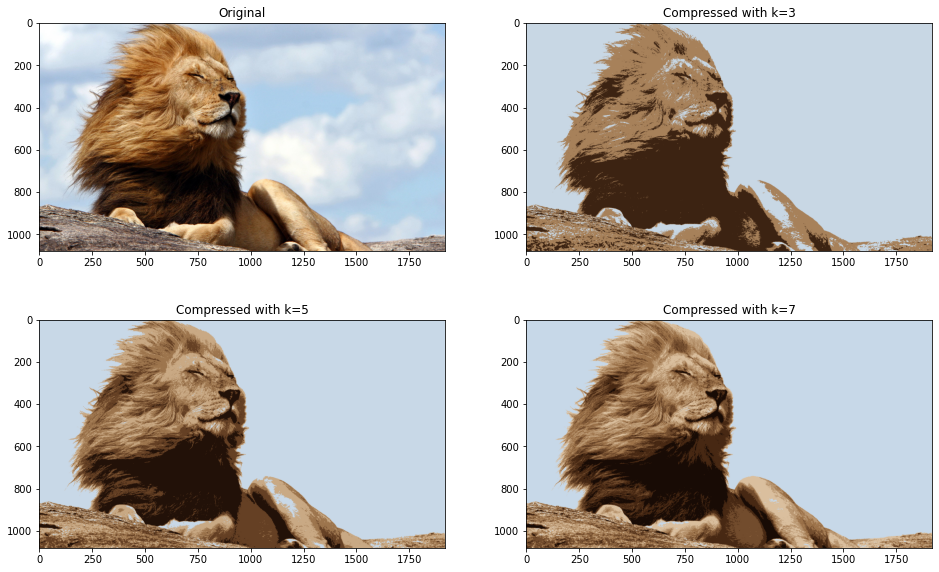

In [ ]:
compress_image(f'img/{list_image_name[0]}', max_iter=70, random_state = 41)

w: algorithm has converged at iters 18/70         

Done
w: algorithm has converged at iters 34/70         

Done
w: algorithm has converged at iters 51/70         

Done


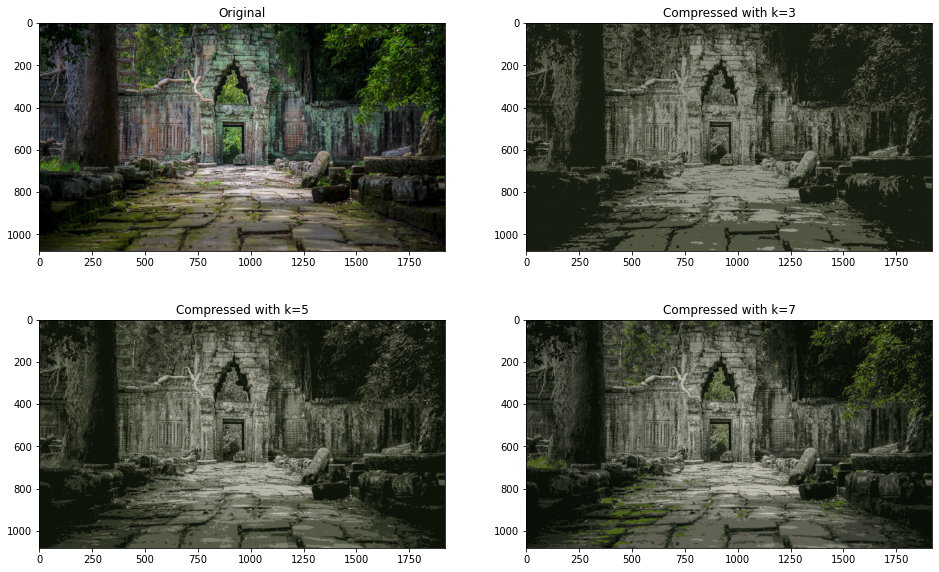

In [ ]:
compress_image(f'img/{list_image_name[1]}', max_iter=70, random_state = 41)

w: algorithm has converged at iters 25/70         

Done
w: algorithm has converged at iters 27/70         

Done
w: algorithm has converged at iters 29/70         

Done


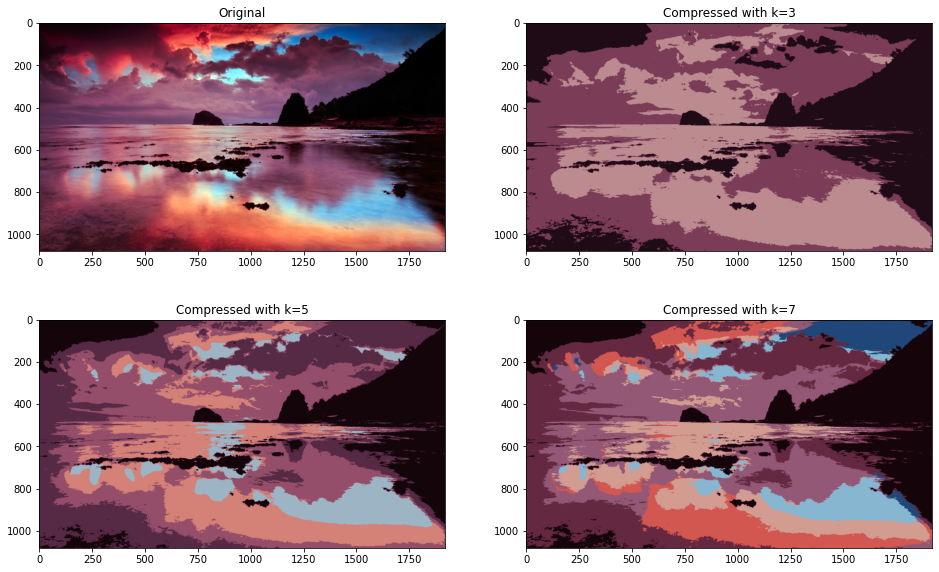

In [ ]:
compress_image(f'img/{list_image_name[2]}', max_iter=70, random_state = 41)

w: algorithm has converged at iters 15/70         

Done
w: algorithm has converged at iters 51/70         

Done
w: algorithm has converged at iters 34/70         

Done


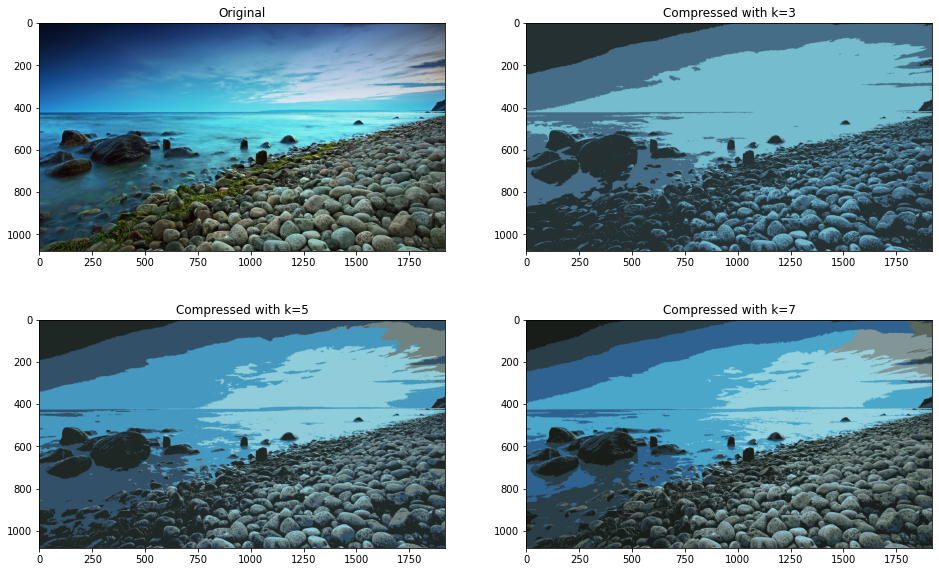

In [ ]:
compress_image(f'img/{list_image_name[3]}', max_iter=70, random_state = 41)

w: algorithm has converged at iters 24/70         

Done
w: algorithm has converged at iters 32/70         

Done
w: algorithm has converged at iters 57/70         

Done


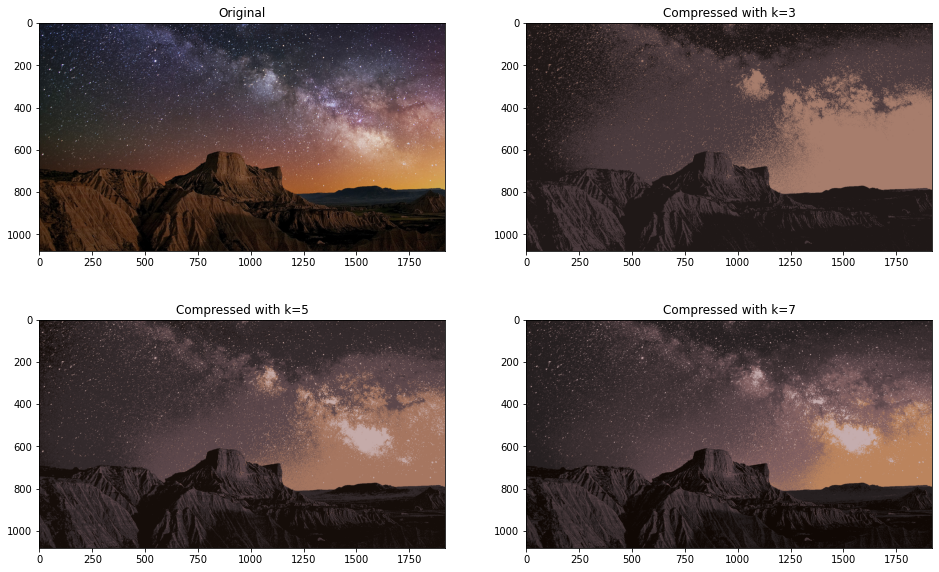

In [ ]:
compress_image(f'img/{list_image_name[4]}', max_iter=70, random_state = 41)

In [ ]:
!zip com.zip Compress* 

  adding: Compressed_African lion 1920x1080.jpg (deflated 7%)
  adding: Compressed_Angkor, Cambodia 1920x1080.jpg (deflated 3%)
  adding: Compressed_Baler, Philippines 1920x1080.jpg (deflated 5%)
  adding: Compressed_Baltic seashore, Germany 1920x1080.jpg (deflated 4%)
  adding: Compressed_Bardenas Reales, Spain 1920x1080.jpg (deflated 3%)


In [ ]:
!ls

'Compressed_African lion 1920x1080.jpg'		      com.zip
'Compressed_Angkor, Cambodia 1920x1080.jpg'	      img
'Compressed_Baler, Philippines 1920x1080.jpg'	      img.zip
'Compressed_Baltic seashore, Germany 1920x1080.jpg'   reduced.png
'Compressed_Bardenas Reales, Spain 1920x1080.jpg'     sample_data
